In [1]:
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from random import sample
import utils
from utils import shuffling
from utils import normalization
from utils import traintestsplit
from utils import feature_extract
import os

In [2]:
epilepsy_data = pd.read_csv("bonn_epilepsy.csv", sep =",")

epilepsy_data.drop("Unnamed",axis=1,inplace=True)
epilepsy_data.head()
epilepsy_data.y = epilepsy_data.y==1
epilepsy_data.y = epilepsy_data.y.astype(int)

epilepsy_data= epilepsy_data[epilepsy_data.isnull().any(axis=1)==False]

label = epilepsy_data["y"].astype("category").to_numpy()
label2 = epilepsy_data["y"]
epilepsy_data.drop("y",axis=1,inplace=True)

In [3]:
epilepsy_data= feature_extract(epilepsy_data)
epilepsy_data= epilepsy_data.iloc[:,-8:]

In [4]:
#normalize the data
normalized = normalization(epilepsy_data, label2)

#shuffle the data
shuffled = shuffling(normalized)

#split the data into train and test sets
X_train, X_test, y_train, y_test = traintestsplit(shuffled,0.25)

In [5]:
np_train_data= X_train
np_test_data= X_test

np_label_train=y_train
np_label_test=y_test


In [6]:
class kNearestNeighbor:

  def __init__(self,train_data, train_label, k=3, dmetric="euclidian"):

    self.train_data= train_data
    self.train_label= train_label
    self.k=k
    self.dmetric=dmetric

        
  def distance_metric(self,vector1,vector2):
    
    if self.dmetric=="manhattan":
      return np.abs(vector1-vector2).sum(axis=1)
    if self.dmetric=="euclidian":
      return np.square(vector1-vector2).sum(axis=1)
  
  def get_neighbors(self, test_data):
    
    distances= self.distance_metric(self.train_data,test_data)
    indices= np.argsort(distances)[:self.k]
    return indices
  
  def predict(self,test_data, test_label):
    y_predict= np.zeros(test_label.shape)
   
    for tt in range(0,test_data.shape[0]):
     
      indx= self.get_neighbors(test_data[tt])
      y_indices= self.train_label[indx]
      y_pred=np.bincount(y_indices).argmax()
      y_predict[tt]=y_pred

    return y_predict
  
                                                    

In [7]:
def test_accuracy(test_label,predicted_label):
  
  print("Accuracy is", round(np.mean(test_label==predicted_label)*100,2))
  return round(100*np.mean(test_label==predicted_label),2)

def class_accuracy(model,data,label):
   class_labels = np.unique(label,return_counts=False)
   class_acc_list = []
   for cl in class_labels: 
        print("Class", cl)
        class_pred= model.predict(data[label==cl],label[label==cl])
        class_acc= test_accuracy(label[label==cl],class_pred)
        #print("Test accuracy for class ", cl, "is : ", class_acc )
        class_acc_list.append(class_acc)

def confusion_matrix_plot(true_label,predictions):
    

    class_labels = np.unique(true_label,return_counts=False)
    
    cm= confusion_matrix(true_label,predictions) 
    cp=ConfusionMatrixDisplay(cm,display_labels=class_labels)
    cp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
def KFoldCrossValidation(data_train,label_train,model="knn", Kfold=5, k=3, metric="euclidian"):
    sample_count= data_train.shape[0]
    fold_size = int(sample_count/Kfold)
    accuracy_all = list()
   
    for ff in range(Kfold):
        
        test_data=data_train[ff*fold_size:(ff+1)*fold_size,:]
        test_label= label_train[ff*fold_size:(ff+1)*fold_size]

        train_data= np.append(data_train[:ff*fold_size,:],data_train[(ff+1)*fold_size:,:],axis=0)
        train_label= np.append(label_train[:ff*fold_size],label_train[(ff+1)*fold_size:],axis=0)
        model= kNearestNeighbor(train_data, train_label,k,metric)
        preds = model.predict(test_data,test_label)
        acc= np.mean(preds==test_label)
        accuracy_all.append(acc)
        print("Fold ",ff+1,"is completed.")
    return sum(accuracy_all)/len(accuracy_all)*100

In [9]:
# K-fold cross validation with grid-search
grid_search = [[3,5,7,11,15],["euclidian","manhattan"]]
accuracy_grid=np.zeros((len(grid_search[0]),len(grid_search[1])))
K_fold=5
import time
b= time.time()
for i,k in enumerate(grid_search[0]):
    for j,m in enumerate(grid_search[1]):
        acc=KFoldCrossValidation(X_train,y_train,Kfold=K_fold,k=k,metric=m)
        print("K-Nearest Neighbor:", k, " Metric: ", m, ": ",round(acc,2))
        accuracy_grid[i][j]=round(acc,2)
e= time.time()
print("Total time for ",K_fold, "-fold is: ", e-b, "seconds.")
def organize_results(grid_search,accuracy_grid):
    
    df=pd.DataFrame(accuracy_grid)
    df.columns = grid_search[1]
    df.set_index(pd.Index(grid_search[0]),inplace=True)
    df.index.name="k"
    return df



Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 3  Metric:  euclidian :  95.74
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 3  Metric:  manhattan :  95.74
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 5  Metric:  euclidian :  96.17
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 5  Metric:  manhattan :  96.13
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 7  Metric:  euclidian :  96.3
Fold  1 is completed.
Fold  2 is completed.
Fold  3 is completed.
Fold  4 is completed.
Fold  5 is completed.
K-Nearest Neighbor: 7  Metric:  manhattan :  96.35
Fold  1 is completed.
Fold  2 is co

In [10]:
# Print the model results

accuracy_table= organize_results(grid_search,accuracy_grid)
import dataframe_image as dfi
dfi.export(accuracy_table, "knn_girdsearch.png")

--------------- TOTAL ACCURACY -------------------
Accuracy is 96.24
********* CLASS BASED ACCURACY********************
Class 0
Accuracy is 97.33
Class 1
Accuracy is 92.06


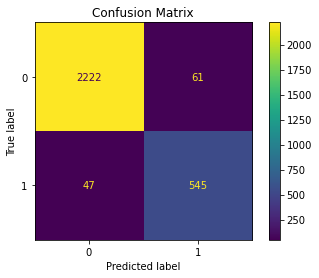

In [11]:
# Automatically select the best model

from numpy import unravel_index
best_index=unravel_index(accuracy_grid.argmax(),  accuracy_grid.shape)
knn_best=  kNearestNeighbor(np_train_data,np_label_train, grid_search[0][best_index[0]],grid_search[1][best_index[1]])
y_pred=knn_best.predict(np_test_data,np_label_test)
print("--------------- TOTAL ACCURACY -------------------")
acc= test_accuracy(np_label_test,y_pred)
print("********* CLASS BASED ACCURACY********************")
class_accuracy(knn_best,np_test_data,np_label_test)
confusion_matrix_plot(np_label_test,y_pred)